In [0]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import urllib2

X_train_file = urllib2.urlopen("https://raw.githubusercontent.com/SalmanMohammadi/ml_data/master/regression/X_train.csv")
X_test_file = urllib2.urlopen("https://raw.githubusercontent.com/SalmanMohammadi/ml_data/master/regression/X_test.csv")
y_train_file = urllib2.urlopen("https://raw.githubusercontent.com/SalmanMohammadi/ml_data/master/regression/y_train.csv")

In [0]:
#Bunch of imports

from sklearn import linear_model
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import copy

In [0]:
#Load the data in
X_train = np.loadtxt(X_train_file, delimiter=',', skiprows=1)
X_test = np.loadtxt(X_test_file, delimiter=',', skiprows=1)
y_train = np.loadtxt(y_train_file, delimiter=',', skiprows=1)

In [0]:
#Scaling
from sklearn import preprocessing

X_train_scaled, X_test_scaled = preprocessing.scale(X_train), preprocessing.scale(X_test)


In [0]:
class BayesianRegression(object):
  
  def __init__(self, order=1, noise=48):
    self.order = order  
    self.sig_sq = noise**2
    
  def fit(self, X, t):
    new_X = np.ones((X.shape[0], 1))
    for i in range(self.order):
      new_X = np.hstack((new_X, X**(i+1)))
    
    order = (self.order*X.shape[1])+1
    
    mu0 = np.zeros((order,1),dtype=np.float)
    sig0 = 100.0*np.identity(order,dtype=np.float)
    sig_w = np.linalg.inv((1.0/self.sig_sq)*np.dot(new_X.T,new_X) + np.linalg.inv(sig0))
   
    self.mu_w = (1.0/self.sig_sq)*np.dot(sig_w,np.dot(new_X.T,t))
       
  def predict(self, X):
    if self.mu_w is not None:
      new_X = np.ones((X.shape[0], 1))
      for i in range(self.order):
        new_X = np.hstack((new_X, X**(i+1)))
        
      return np.dot(new_X,self.mu_w)
    else:
      print("Fit the model first!")
      
  def clone(self):
    return copy.copy(self)

In [0]:
class LinearRegression(object):
  
  def __init__(self, order=1):
    self.order = order  
    
  def fit(self, X, t):
    new_X = np.ones((X.shape[0], 1))
    for i in range(self.order):
      new_X = np.hstack((new_X, X**(i+1)))
      
    self.w = np.linalg.pinv(new_X.T.dot(new_X)).dot(new_X.T.dot(t))

  def predict(self, X):
    if self.w is not None:
      new_X = np.ones((X.shape[0], 1))
      for i in range(self.order):
        new_X = np.hstack((new_X, X**(i+1)))
      
      return new_X.dot(self.w)
    else:
      print("Fit the model first!")
      
  def clone(self):
    return copy.copy(self)

In [0]:
#Util function for cross validation
from sklearn.model_selection import KFold

def cross_val_score(X_train, y_train, model, n_splits=3, average=False, shuffle=True, root_mse=False):
  if n_splits == None:
    n_splits = len(X_train)
    
  kf = KFold(n_splits=n_splits, shuffle=shuffle)
  scores = []
  for train_index, test_index in kf.split(X_train):
    X_train_data, X_test_data = X_train[train_index], X_train[test_index]
    y_train_data, y_test_data = y_train[train_index], y_train[test_index]

    clf = model.clone()
    clf.fit(X_train_data, y_train_data)
    predictions = clf.predict(X_test_data)
    if root_mse:
      mse = np.sqrt(mean_squared_error(y_test_data, predictions))
    else:
      mse = mean_squared_error(y_test_data, predictions)
    scores.append(mse)
    
  if average:
    return np.mean(scores)
  
  return scores
    

Text(0.5,0,u'Bayesian noise value')

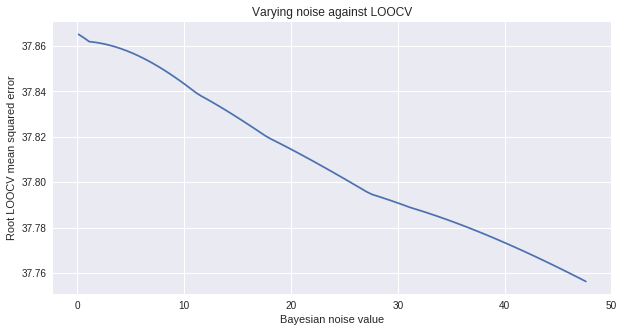

In [9]:
#LOOCV mean squared error against an increasing noise value

noises = np.arange(0.1, 48, 0.5)
scores = []
for noise in noises:
  scores.append(cross_val_score(X_train, y_train[:,1], BayesianRegression(order=3, noise=noise), n_splits=None, average=True, root_mse=True))
  
plt.figure(figsize=(10, 5))
plt.plot(noises, scores)
plt.title("Varying noise against LOOCV")
plt.ylabel("Root LOOCV mean squared error")
plt.xlabel("Bayesian noise value")


[42.87676148200624, 33.302890536846974, 37.75524764438373]
[44.57035090890282, 36.539503672293186, 35.15385899285138]
[44.784661842938846, 35.225838508178036, 55.18210297348672]


Text(0,0.5,u'Average LOOCV mean squared error')

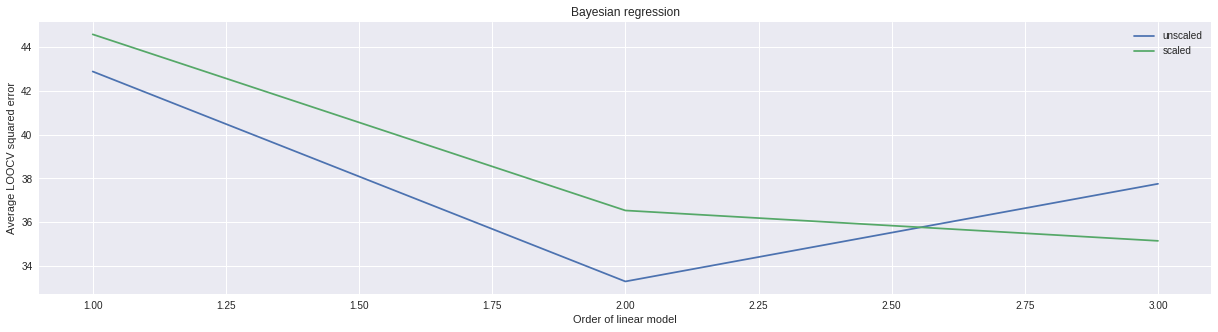

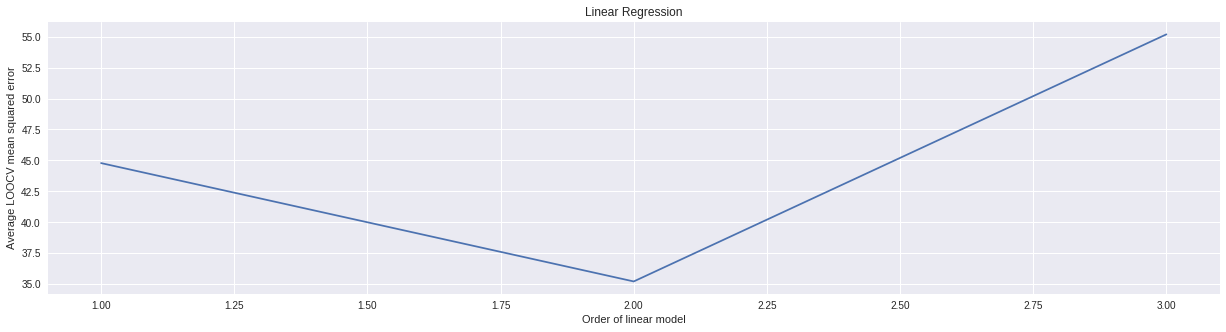

In [10]:
#Run some experiments to see how well linear regression performs for different orders 

orders = [1, 2, 3]

plt.figure(figsize=(21,5))
scores = []

for order in orders:
  scores.append(cross_val_score(X_train, y_train[:,1], BayesianRegression(order=order), n_splits=None, average=True, root_mse=True))

print(scores)
plt.plot(orders, scores, label="unscaled")
plt.xlabel("Order of linear model")
plt.ylabel("Average LOOCV squared error")
plt.title("Bayesian regression")

scores = []

for order in orders:
  scores.append(cross_val_score(X_train_scaled, y_train[:,1], BayesianRegression(order=order), n_splits=None, average=True,  root_mse=True))

print(scores)
plt.plot(orders, scores, label="scaled")
plt.legend()

plt.figure(figsize=(21,5))
scores = []
  
for order in orders:
  scores.append(cross_val_score(X_train, y_train[:,1], LinearRegression(order=order), n_splits=None, average=True,  root_mse=True))
  
print(scores)

plt.plot(orders, scores, label="unscaled")
plt.title("Linear Regression")
plt.xlabel("Order of linear model")
plt.ylabel("Average LOOCV mean squared error")



('Bayesian scores:', [44.57035090890281, 36.53950367229319, 35.15385899285138, 89.31768615502523, 343.9314296393388])
('Linear scores:', [44.784661842938846, 35.225838508178036, 55.18210297348672, 58.62850913767748, 69.55159214646525])


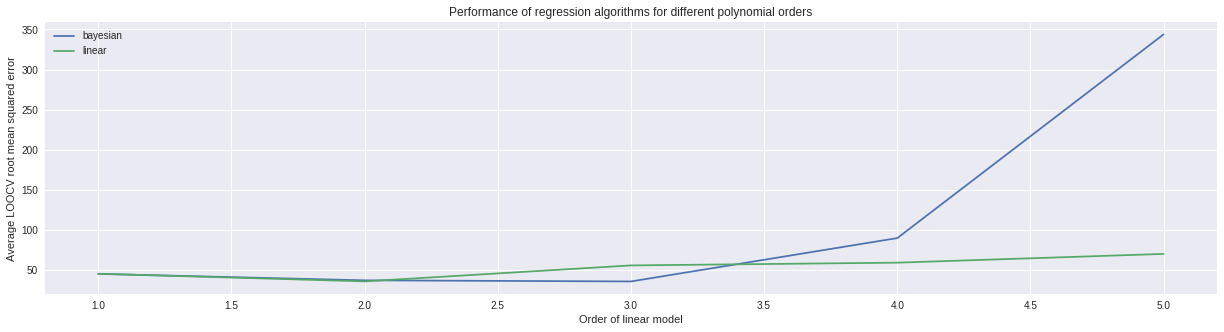

In [11]:
#Comparing the performance of our two algorithms

orders = [1, 2, 3, 4, 5]

plt.figure(figsize=(21,5))

scores = []
for order in orders:
  scores.append(cross_val_score(X_train_scaled, y_train[:,1], BayesianRegression(order=order, noise=48), n_splits=None, average=True,  root_mse=True))

print("Bayesian scores:", scores)
plt.plot(orders, scores, label="bayesian")

scores = []
for order in orders:
  scores.append(cross_val_score(X_train, y_train[:,1], LinearRegression(order=order), n_splits=None, average=True,  root_mse=True))
  
print("Linear scores:", scores)
plt.plot(orders, scores, label="linear")

plt.xlabel("Order of linear model")
plt.ylabel("Average LOOCV root mean squared error")
plt.title("Performance of regression algorithms for different polynomial orders")
plt.legend()



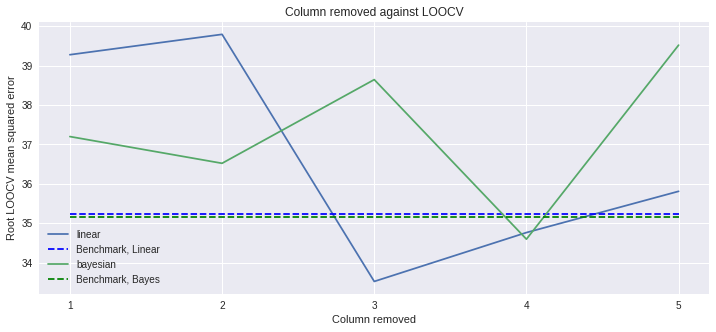

In [12]:
#Testing for possible performance improvement by removing features from the data

model1 = LinearRegression
model2 = BayesianRegression

columns = range(1,X_train.shape[1])
scores = [[],[]]

threshold_score = cross_val_score(X_train, y_train[:,1], model1(order=2), n_splits=None, average=True, root_mse=True)
threshold_score_l = np.full(len(columns), threshold_score)

threshold_score = cross_val_score(X_train_scaled, y_train[:,1], model2(order=3), n_splits=None, average=True, root_mse=True)
threshold_score_b = np.full(len(columns), threshold_score)

for column in columns:
  new_x_train = np.delete(X_train , column, axis=1)
  clf = model1(order = 2)
  clf.fit(new_x_train, y_train[:,1])
  scores[0].append(cross_val_score(new_x_train, y_train[:,1], clf, n_splits=None, average=True, root_mse=True))
  
  new_x_train = np.delete(X_train_scaled , column, axis=1)
  clf = model2(order = 3)
  clf.fit(new_x_train, y_train[:,1])
  scores[1].append(cross_val_score(new_x_train, y_train[:,1], clf, n_splits=None, average=True, root_mse=True))

plt.figure(figsize=(12,5))
plt.plot(columns, scores[0], label="linear")
plt.plot(columns, threshold_score_l, "k--", label="Benchmark, Linear", color='blue')
plt.plot(columns, scores[1], label="bayesian")
plt.plot(columns, threshold_score_b, "k--", label="Benchmark, Bayes", color='green')
plt.xlabel("Column removed")
plt.ylabel("Root LOOCV mean squared error")
plt.title("Column removed against LOOCV")
plt.xticks(columns)

plt.legend()

In [0]:
#Putting the above scores in a table format to compare with the benchmarked scores

columns = range(X_train.shape[1])

scores_linear = [] 
scores_bayes = []

clf = LinearRegression(order = 2)
scores_linear.append(cross_val_score(X_train, y_train[:,1], clf, n_splits=None, average=True, root_mse=True))
clf = BayesianRegression(order = 3)
scores_bayes.append(cross_val_score(X_train_scaled, y_train[:,1], clf, n_splits=None, average=True, root_mse=True))

  
for column in columns:
  new_x_train = np.delete(X_train , column, axis=1)
  clf = LinearRegression(order = 2)
  scores_linear.append(cross_val_score(new_x_train, y_train[:,1], clf, n_splits=None, average=True, root_mse=True))
  
  new_x_train = np.delete(X_train_scaled , column, axis=1)
  clf = BayesianRegression(order = 3)
  scores_bayes.append(cross_val_score(new_x_train, y_train[:,1], clf, n_splits=None, average=True, root_mse=True))


In [14]:
import pandas as pd

df = pd.DataFrame({"Features missing":["all", "missing 0", "missing 1", "missing 2","missing 3","missing 4","missing 5"],
             "Linear Score": scores_linear, "Bayesian Score": scores_bayes})
df = df[["Features missing", "Bayesian Score", "Linear Score"]]
df

,Features missing,Bayesian Score,Linear Score
0,all,35.153859,35.225839
1,missing 0,34.392164,35.399584
2,missing 1,37.200393,39.277538
3,missing 2,36.522022,39.794362
4,missing 3,38.645600,33.523527
5,missing 4,34.596305,34.764243
6,missing 5,39.521060,35.811054


In [0]:
# Arrange answer in two columns. First column (with header "Id") is an
# enumeration from 0 to n-1, where n is the number of test points. Second
# column (with header "EpiOrStroma" is the predictions.
test_header = "Id,PRP"
n_points = X_test.shape[0]
y_pred_pp = np.ones((n_points, 2))
y_pred_pp[:, 0] = range(n_points)
y_pred_pp[:, 1] = y_pred
np.savetxt('my_submission.csv', y_pred_pp, fmt='%d', delimiter=",",
           header=test_header, comments="")

#Uncomment these for using Colab
# from google.colab import files
# files.download('my_submission.csv')
# Note: fmt='%d' denotes that all values should be formatted as integers which
# is appropriate for classification. For regression, where the second column
# should be floating point, use fmt='%d,%f'. 